In [1]:
import pandas as pd

# Download the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

# Load the dataset into a DataFrame
adult_data = pd.read_csv(url, header=None, names=column_names, na_values=" ?", skipinitialspace=True)

# Display the first few rows of the dataset
print(adult_data.head())

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

In [2]:
# Drop rows with missing values
adult_data.dropna(inplace=True)

# Encode categorical variables
adult_data = pd.get_dummies(adult_data, drop_first=True)

# Separate features and target
X = adult_data.drop("income_>50K", axis=1)
y = adult_data["income_>50K"]

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.89      0.93      0.91      7455
        True       0.73      0.63      0.68      2314

    accuracy                           0.86      9769
   macro avg       0.81      0.78      0.79      9769
weighted avg       0.85      0.86      0.85      9769



# **SHAP (SHapley Additive exPlanations)**

<Figure size 640x480 with 0 Axes>

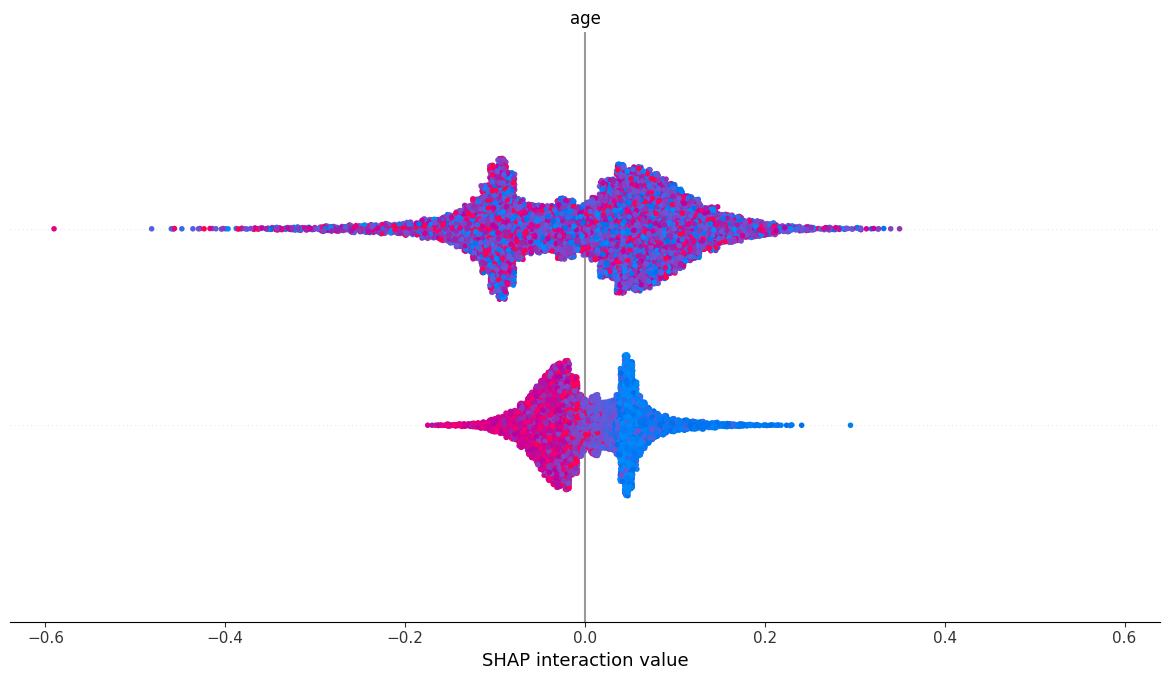

In [4]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar")

# **Explanation of  SHAP Results**

*   **Output**: The SHAP summary plot reveals which features have the most significant impact on the model's predictions.

*    **Interpretation**: Each dot in the plot represents a SHAP value for a feature and an instance. Features are ranked by their importance. A positive SHAP value indicates that the feature contributes to predicting a higher income (>50K), while a negative value suggests a contribution towards a lower income (<=50K).
*   **Feature Interactions**: SHAP values also capture interactions between features, providing a more nuanced understanding of how features work together to influence predictions.





In [5]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0daef6e4283362dec01c1476510bb3e79d23a7e894e1a6203359b73ad21b0eb7
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


#  **LIME (Local Interpretable Model-agnostic Explanations)**

In [6]:
from lime.lime_tabular import LimeTabularExplainer

# Create a LIME explainer
explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=["<=50K", ">50K"], mode="classification")

# Explain a prediction
i = 0  # Index of the instance to explain
exp = explainer.explain_instance(X_test.values[i], model.predict_proba)
exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# **Explanation of LIME Results**
*  **Output**: LIME provides an explanation for a specific prediction, typically displaying how each feature contributes to that instance's predicted class.
*  **Interpretation**: The explanation includes a table or visualization showing feature contributions. Positive contributions push the prediction towards >50K, while negative contributions push it towards <=50K.
*  **Local Focus**: Unlike SHAP, which provides a global view, LIME focuses on individual predictions. This is beneficial for understanding specific cases, such as why a particular individual is predicted to have an income greater than $50K.


# **Partial Dependence Plots (PDP)**

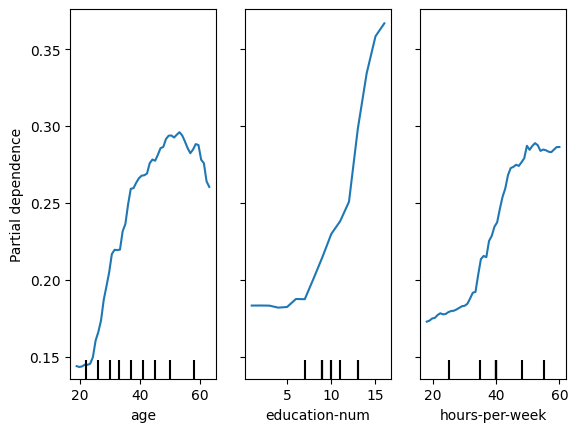

In [9]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Plot Partial Dependence
features = ['age', 'education-num', 'hours-per-week']  # Choose features to analyze
disp = PartialDependenceDisplay.from_estimator(model, X_train, features, grid_resolution=50)
plt.show()

# **Explanation of Partial Dependence Plots (PDP) Results**
*  **Output:** The Partial Dependence Plots display how the predicted probability of earning >50K changes as each selected feature varies, while holding all other features constant.

*  I**nterpretation:** Each plot corresponds to one feature (age, education-num, hours-per-week). The x-axis shows the range of values for the feature, and the y-axis indicates the average predicted probability of the target class (>50K income).

*  **Insights:**

      *  Age: The plot may show that as age increases, the probability of earning >50K generally rises, indicating that older individuals tend to have higher incomes. This trend may reflect accumulated experience and career advancement.

      * Education Level (education-num): This plot typically illustrates a positive correlation between education level and income. As the education level increases, the likelihood of earning >50K increases significantly, highlighting the impact of higher education on income potential.

      * Hours per Week (hours-per-week): The plot likely reveals that individuals who work more hours per week have a higher probability of earning >50K. This suggests that increased work hours correlate with higher earnings, emphasizing the importance of labor input in determining income.


# **Discuss the advantages and disadvantages of each XAI technique in terms of model interpretability.**

1. **SHAP (SHapley Additive exPlanations)**

**Advantages:**

* **Theoretical Foundation:** SHAP values are based on game theory, providing a solid mathematical basis for feature contributions, which enhances trust in the results.
* **Global and Local Interpretability:** SHAP offers both global insights (overall feature importance) and local explanations (individual predictions), making it versatile for different interpretability needs.
* **Feature Interactions:** SHAP captures interactions between features, providing a more comprehensive understanding of how features influence predictions together.

**Disadvantages:**

* **Computational Complexity:** Calculating SHAP values can be computationally intensive, especially for complex models or large datasets, which may hinder real-time interpretation.
* **Interpretation Difficulty:** For non-experts, understanding SHAP values may require additional explanation, as the concept of additive contributions might be abstract.

2. **LIME (Local Interpretable Model-agnostic Explanations)**

**Advantages:**

* **Local Interpretability:** LIME provides explanations for individual predictions, making it easy to understand specific cases and how certain features influence a particular decision.
* **User-Friendly:** The results are often presented in an intuitive format (e.g., bar charts), making them accessible to non-technical stakeholders.
Flexibility: LIME can be applied to any model type, offering a model-agnostic approach to interpretability.

**Disadvantages:**

* **Sensitivity to Parameters:** The explanations can be sensitive to the choice of neighborhood around the instance being explained, which may lead to variability in results.
* **Limited Global Insights**: While LIME excels at local explanations, it does not provide a global view of feature importance across the entire dataset, limiting its usefulness for understanding overall model behavior.

3. **Partial Dependence Plots (PDP)**

**Advantages:**

* **Simplicity:** PDPs are straightforward to understand and interpret, visually showing the relationship between a feature and the predicted outcome.
* **Global Insights:** They provide a global view of how a feature affects predictions across the entire dataset, allowing for easy identification of trends.
* **No Additional Model Complexity:** PDPs do not require additional modeling or complex calculations beyond the initial model, making them easy to generate.

**Disadvantages:**

* **Assumption of Independence:** PDPs assume that features are independent when estimating their effects, which can be misleading if features are correlated.
* **Limited Interaction Insights:** While PDPs show the marginal effect of a feature, they do not capture interactions between multiple features, which can provide a skewed understanding of their effects.